# Steps für Topic Modeling

# Step 1: Einlesen der bereinigten Daten
# Step 2: Filtern nach Genre 'Rap' und Sprache 'Englisch'
# Step 3: Bereinigung der Texte
# Step 4: Tokenization und Lemmatizer
# Step 5: Stop words
# Step 6: Parameter für Modell bestimmen
# Step 7: LDA Modell anwenden
# Step 8: Topics erkunden
# Step 9: Topics visualisieren



In [13]:
import pandas as pd
from config import data_input_path, kaggle_output_dir

In [15]:
df_raw = pd.read_csv(data_input_path)

In [27]:
num_lyrics = 10_000

df = df_raw.sample(num_lyrics)

Batchs of data are randomly loaded in the memory. The number of batchs loaded depends on the memory capacity of the computer running the script. For the analysis, we will only works on the random samples loaded (All the data in Kaggle).  

# Exploring the coarse data

Let's visualize and explore the coarse data before a part of deeper analysis.

In [3]:
df.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
2000000,Roses,rock,Vitja,2017,399,{},The roses start to wither\nWhere the devil lay...,3019113,en,en,en
2000001,Keep On Pushin,rap,Problem,2017,692,"{""My Princess Aeryn""}",[Hook]\nImma keep on pushin\nImma keep on push...,3019114,en,en,en
2000002,Inside,pop,The jepettos,2017,1302,{},"[Intro]\nOoh, ooh, ah, ah (x2)\n\n[Verse 1]\nI...",3019115,en,en,en
2000003,Girls Like You,rb,PnB Rock,2017,60114,{},[Chorus]\nBaby it was real\nYeah we were the b...,3019117,en,en,en
2000004,Froideur,rap,N'Dirty Deh,2017,5813,"{""N\\'Dirty Deh""}","[Refrain]\nEt j'ai perdu la foi, mais c'est pa...",3019120,fr,fr,fr


For each songs, we've got several informations :
- title of the song
- the tag (genre)
- the artist singer name
- the release year
- the number of page views
- the featuring artists names
- the lyrics
- the genius identifier
- Lyrics language according to [CLD3](https://github.com/google/cld3). Not reliable results are NaN. CLD3 is a neural network model for language indentification.
- Lyrics language according to [FastText's langid](https://fasttext.cc/docs/en/language-identification.html). Values with low confidence (<0.5) are NaN. FastText's langid is library developped by Facebook’s AI Research lab for efficient learning of word representations and sentence classification. fastText has also published a fast and accurate tool for text-based language identification capable of recognizing more than 170 languages.
- Combines language_cld3 and language_ft. Only has a non NaN entry if they both "agree".

In [5]:
df.dtypes

title            object
tag              object
artist           object
year              int64
views             int64
features         object
lyrics           object
id                int64
language_cld3    object
language_ft      object
language         object
dtype: object

In [6]:
# display the size
print('Data frame size (row x columns):', df.size)
print('Data rows number: ', len(df))
print('Number of unique songs (following genius id): ', len(df.id.unique()))

Data frame size (row x columns): 11000000
Data rows number:  1000000
Number of unique songs (following genius id):  1000000


Genius id seems to be the unique rows identifier.

Let's vizualise size of the coarse data over years before preprocessing to compare batch distributions. One things to know before vizualise the data, the pickles are create by chunks reading. 

The last diplayed table gives us some information about the data. The csv file seems to be sort by id, so the pickle files are then sort too.

In [4]:
import os
import pandas as pd
import plotly.express as px

In [5]:
# get some information about the pickle data
def pickle_informations(loader: Loader):
    rows = []
    for i in range(1, len(os.listdir('data')) + 1):
        df = loader.load_pickle(i)
        rows.append(len(df))
        del df
    return rows

# get the rows
rows = pickle_informations(loader=loader)

# create the dataframe
df_data = pd.DataFrame(
    {'batch' : ['data ' + str(i) for i in range(1,len(rows) + 1)],
    'rows' : rows})

fig = px.bar(df_data, x="batch", y="rows")
fig.show()

Batch seems to have the same number of rows rexcept for the last one which is consistent because batch are create iteratively by 10e6 chunks over the csv The last batch could be seen as a rest.

In [9]:
from utils.plots import multi_barplot
import plotly.colors as col

# create the color list
colors = col.qualitative.Plotly

# 1990 - 2023
fig1 = multi_barplot(year1=1960, year2=1989, colors=colors, loader=loader)
fig1.show()
# 1960 - 1990
fig2 = multi_barplot(year1=1990, year2=2023, colors=colors, loader=loader)
fig2.show()

The first bar chart (1960 - 1989) shows an increasing numbers of data over years. Moreover batch seems to have quite similar distriutions over years. data_1 and data_2 batch quite outperform the 4 others. data_6 batch is weaker than the other due to its poor number of rows.
The data behaves similarly until 2012 as we can see on the second chart (1990-2023). After this year there is great increasing of the data retrieved. A minimum increase of at least 100% of the batch can be observed. An increase of up to 50 times the batch size for some.

# Data pre-processing

The aim of this part is to preprocess data in order to get suitable data for the analysis. let's focus on the year variable.

We will focus on English songs, to facilitate the analysis and the work of natural language processing algorithms.

In [28]:
# filter by language
df = df[df.language == 'en']

# filter by genre
df = df[df.tag == 'rap']

## Clean lyrics

In [29]:
# get the first lyrics
df.iloc[0]["lyrics"]

"[Intro}\nUh, its ya boy who you?\nYeah yeah aye\n\n[Verse 1 Alex Wiley]\nThe way I feel, aye its like I'm all that shit\nUh, and the way I feel\nAye, we don't owe you shit\nAye aye\nI take a dub of the target\nAnd cop a whole ass fit, uh\nCryptic on the phone keep it cautious\nCause I don't trust that bitch\nAye aye\nUh, I'm the affirmationer\nRap game information age\nBlast on, penetration age\nThat's that generation age\nThat's that, that's that moving state to state\nBut don't nobody give a fuck bout that\nNiggas talk shit but ain't bout that\nYou bitch where yo house at?\n[Bridge]\nNigga, I don't mean to offend ya\nBut you are no contender\nI just came off a bender\nAnd I am the descendant of gods\nI am the descendant of gods\n\n[Hook]\nSo motherfucker just don't be surprised\nWhen I takeoff, when I take flight\nWhen I go crazy, when I go dumb\nBitch I go dumb\nOooh ooh oooh oh [4x]\n\n[Alex Wiley vocals]\n\n[Verse 2 Kembe X]\nAye, aye\nWooooo\nLook it, I'm sittin' crooked, aye\nI

There is many undesirable characters like the line breaker '\n', figures or square, curly and simple brackets. So let's clean this data with regular expressions.

In [30]:
import re
from numpy.random import randint

def clean_text(text):
    # remove \n
    text = text.replace('\n', ' ')
    # remove punctuation
    text = re.sub(r'[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub(r'\[.*?\]', ' ', text)
    #removing numbers
    text = re.sub(r'\w*\d\w*',' ', text)
    #removing bracket
    text = re.sub(r'[()]', ' ', text)
    # convert all words in lower case
    text = text.lower()
    return text

In [31]:
# get the results of data cleaning
cleaned_text = df["lyrics"].apply(clean_text)

# convert cleaned text to list
docs = cleaned_text.to_list()
docs[0]

"  the way i feel aye its like i'm all that shit uh and the way i feel aye we don't owe you shit aye aye i take a dub of the target and cop a whole ass fit uh cryptic on the phone keep it cautious cause i don't trust that bitch aye aye uh i'm the affirmationer rap game information age blast on penetration age that's that generation age that's that that's that moving state to state but don't nobody give a fuck bout that niggas talk shit but ain't bout that you bitch where yo house at   nigga i don't mean to offend ya but you are no contender i just came off a bender and i am the descendant of gods i am the descendant of gods    so motherfucker just don't be surprised when i takeoff when i take flight when i go crazy when i go dumb bitch i go dumb oooh ooh oooh oh         aye aye wooooo look it i'm sittin' crooked aye i hope them coppas don't look at me they probably throw the whole book at me and i ain't pressing her for pussy no maybe ducats aye cause i been living off a dream i been s

In [32]:
# update dataframe
df.update(cleaned_text)
df.head(3)

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
367376,Takeoff Takeoff,rap,Alex Wiley,2014,2263,"{""Kembe X""}",the way i feel aye its like i'm all that shi...,532816,en,en,en
2761879,Poseidon,rap,Damon,2018,50,{},hook: they sayin what’s that damon how you do ...,4150679,en,en,en
4001165,Double Up Audio,rap,Nipsey Hussle,2018,117,"{""DOM KENNEDY"",Belly}",turned seven to a to a whole thing lord ...,6051349,en,en,en


In [33]:
df.iloc[0]['lyrics']

"  the way i feel aye its like i'm all that shit uh and the way i feel aye we don't owe you shit aye aye i take a dub of the target and cop a whole ass fit uh cryptic on the phone keep it cautious cause i don't trust that bitch aye aye uh i'm the affirmationer rap game information age blast on penetration age that's that generation age that's that that's that moving state to state but don't nobody give a fuck bout that niggas talk shit but ain't bout that you bitch where yo house at   nigga i don't mean to offend ya but you are no contender i just came off a bender and i am the descendant of gods i am the descendant of gods    so motherfucker just don't be surprised when i takeoff when i take flight when i go crazy when i go dumb bitch i go dumb oooh ooh oooh oh         aye aye wooooo look it i'm sittin' crooked aye i hope them coppas don't look at me they probably throw the whole book at me and i ain't pressing her for pussy no maybe ducats aye cause i been living off a dream i been s

# Topic modeling

- [LDA (latent dirichlet allocation)](https://fr.wikipedia.org/wiki/Allocation_de_Dirichlet_latente) are the common way to do topic modeling in the few last years, it works and it's quite easy to use with common python library like [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html).

## Define default tokenizer and Lemmatizer

In [2]:
from utils.terms_document_matrix import TermsDocumentsMatrix
from utils.processing import preprocess

set gpu:  False


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
# first decades
tdm = TermsDocumentsMatrix(df, decades = [1960, 1970, 1980, 1990],
                           colorscale = 'Plasma')

# display bar charts of most frequent terms
tdm.most_freq_terms(n_rows = 2, n_cols = 2, n_terms = 15)

According to the bar graphs displayed above, a group of words seems to recur on each decade: Love, know, go, feel ... Words that seem to relate to the popular song that can talk about love. This is consistent with our previous analysis from the pie charts showing the proportions of musical styles across time. We also notice an important presence of onomatopoeia like yeah or oh.

In [ ]:
# first decades
tdm = TermsDocumentsMatrix(df, decades = [2000, 2010, 2020],
                          colorscale = 'Plasma')

# most frequent terms
tdm.most_freq_terms(n_rows = 2, n_cols = 2, n_terms = 15)

We get similar results on this second decade with similar high occurrence words. We see a greater amount of onomatopoeia in the current decade. We can explain this by an emergence of the rap music style on this current and last decade. There is in this style of music a very used process, the 'ad-libs'. They are sounds, words or onomatopoeias that the artists pronounce sometimes between two verses or at the end of a sentence to give more impact to their text and to dynamize the atmosphere of a title. This may explain the greater presence of onomatopoeia in the lyrics of this decade.


## Topic modeling with LDA

LDA is a common technic use in topic modeling, we firstly process basic preprocessing.

In [50]:
import nltk

In [51]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.lyrics])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [53]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.lyrics])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [54]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [55]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [56]:
# Filter for bigrams with only noun-type structures
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_word_list = set(stopwords.words('english'))

def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niklasfischer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
nltk.download('averaged_perceptron_tagger_eng')
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/niklasfischer/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [59]:
# examples of bigrams
bigrams[:10]

['hottie pump',
 'new york',
 'verse :',
 'brand new',
 "talkin' 'bout",
 'aye aye',
 'hey hey',
 'need xans',
 'yea yea',
 'ayy ayy']

In [60]:
# examples of trigrams
trigrams[:10]

['aye aye aye', 'yeah yeah yeah', "feel like i'm"]

In [61]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [63]:
lyrics_w_ngrams = df.copy()
lyrics_w_ngrams.reviewText = lyrics_w_ngrams.lyrics.map(lambda x: replace_ngram(x))

/var/folders/t9/_f2xrzm14kj45mrwmnf_8lnr0000gn/T/ipykernel_6782/860781851.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  lyrics_w_ngrams.reviewText = lyrics_w_ngrams.lyrics.map(lambda x: replace_ngram(x))


In [64]:
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
lyrics_w_ngrams = lyrics_w_ngrams.lyrics.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                            #   and word not in english_names\
                                                              and len(word) > 2])

In [77]:
lyrics_w_ngrams.head()

367376     [way, feel, aye, like, i'm, shit, way, feel, a...
2761879    [hook:, sayin, what’s, damon, autopilot, cruis...
4001165    [turned, seven, whole, thing, lord, knows, col...
1999640    [damni, remember, ain't, havin, ice, niggas, c...
4851933    [poof, jump, high, jump, high, jump, ooh, fuck...
Name: lyrics, dtype: object

In [101]:
from gensim import corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords


nltk.download('stopwords')

# Allgemeine Stop-Wörter
common_stop_words = {
    "a", "an", "and", "are", "as", "at", "be", "by", "for", "from", "he", "her",
    "his", "I", "in", "is", "it", "me", "my", "of", "on", "or", "she", "so",
    "that", "the", "to", "up", "was", "we", "with", "you", "i'm", "i've", "i'll", "i'd", "i", "im", "it's", "its", "don't", "dont", "i’m", "i’ve", "i’ll", "i’d", "i", "im", "it’s", "its", "don’t", "dont",
}

# Spezifische Rap-Stop-Wörter
rap_specific_stop_words = {
    "ain't", "yeah", "yea", "yo", "uh", "huh", "gonna", "wanna", "hey", "ooh", "woo",
    "nah", "got", "gotcha", "cuz", "y'all", "imma", "lil", "flex"
}

# Kombiniertes Set von Stop-Wörtern
rap_stop_words = common_stop_words.union(rap_specific_stop_words)

# concatenate the stop words
stop_words = set(stopwords.words('english')).union(rap_stop_words)

# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

def preprocess_lyrics(lyrics):
    return [word for word in lyrics if word not in stop_words]

lyrics = lyrics_w_ngrams.map(preprocess_lyrics)
final_lyrics = lyrics.map(noun_only)
dictionary = corpora.Dictionary(final_lyrics)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_lyrics]



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niklasfischer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
import gensim

coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_lyrics,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


In [81]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

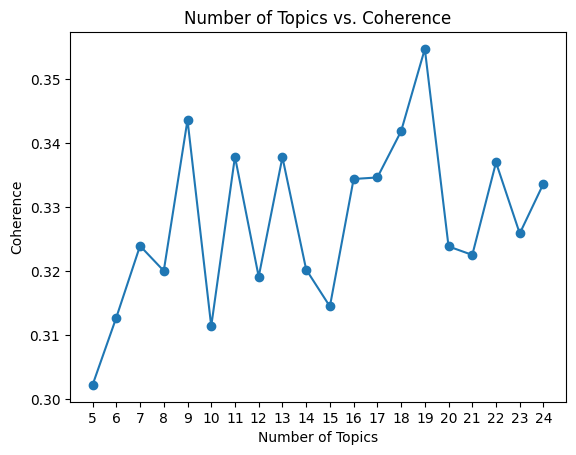

In [82]:
from matplotlib import pyplot as plt

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [102]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=19, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [107]:
ldamodel.show_topics(19, num_words=30, formatted=False)

[(0,
  [('fuck', 0.016375111),
   ('bitch', 0.015294865),
   ('shit', 0.015105105),
   ('ass', 0.0091074165),
   ('feel', 0.008946937),
   ("what's", 0.008757994),
   ('man', 0.00852324),
   ('nigga', 0.007496395),
   ('dope', 0.0074939528),
   ('boy', 0.0073243417),
   ("that's", 0.0067063384),
   ('game', 0.0061417134),
   ('cause', 0.0058670975),
   ('trap', 0.005757183),
   ('way', 0.0056176335),
   ("talkin'", 0.005519285),
   ("fuckin'", 0.0053438754),
   ('mine', 0.004956918),
   ('time', 0.004693549),
   ('please', 0.0046145236),
   ('jumpin’', 0.004550265),
   ('sorry', 0.004476767),
   ('dirty', 0.004434263),
   ("servin'", 0.0043934844),
   ('reason', 0.004351171),
   ('head', 0.0043233316),
   ("they've", 0.0042369626),
   ('rap', 0.0041095573),
   ('gotta', 0.0040950854),
   ("can't", 0.004006426)]),
 (1,
  [('life', 0.032419436),
   ('time', 0.016982527),
   ('way', 0.016149662),
   ('cause', 0.010754786),
   ('world', 0.01069346),
   ('man', 0.010609409),
   ('day', 0.00

In [108]:
import pyLDAvis.gensim

topic_data =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa', R=10, sort_topics=False)
pyLDAvis.display(topic_data)

In [48]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import nltk

# NLTK-Stopwörter herunterladen
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Datenvorverarbeitung und Tokenisierung
def preprocess_lyrics(lyrics):
    return [word for word in simple_preprocess(lyrics) if word not in stop_words]


df['tokens'] = df['lyrics'].apply(preprocess_lyrics)


# Erstelle Wörterbuch und Korpus
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# LDA-Modellierung
num_topics = 23
lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=num_topics, 
    random_state=42, 
    update_every=1, 
    chunksize=10,
    passes=20, 
    alpha='auto', 
    per_word_topics=True
)

# Themen anzeigen
for idx, topic in lda_model.print_topics(num_words=15):
    print(f"Topic {idx}: {topic}")



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niklasfischer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0: 0.007*"sweet" + 0.006*"lovely" + 0.006*"space" + 0.005*"bon" + 0.005*"covered" + 0.005*"rhyme" + 0.005*"must" + 0.004*"stomping" + 0.004*"bonita" + 0.003*"bringing" + 0.003*"spitting" + 0.003*"wild" + 0.003*"focus" + 0.003*"apple" + 0.003*"voice"
Topic 1: 0.022*"like" + 0.015*"know" + 0.013*"get" + 0.010*"got" + 0.009*"never" + 0.009*"love" + 0.008*"make" + 0.008*"cause" + 0.008*"go" + 0.008*"back" + 0.007*"time" + 0.007*"wanna" + 0.007*"say" + 0.007*"see" + 0.006*"let"
Topic 2: 0.031*"yeah" + 0.026*"got" + 0.025*"bitch" + 0.023*"like" + 0.022*"shit" + 0.022*"niggas" + 0.021*"nigga" + 0.018*"fuck" + 0.017*"get" + 0.009*"bout" + 0.008*"yo" + 0.008*"know" + 0.008*"em" + 0.008*"bands" + 0.008*"money"
Topic 3: 0.020*"coke" + 0.015*"um" + 0.011*"hop" + 0.007*"simply" + 0.007*"level" + 0.007*"throat" + 0.006*"yi" + 0.006*"flows" + 0.005*"knowledge" + 0.005*"cat" + 0.005*"potato" + 0.005*"carter" + 0.005*"aiy" + 0.005*"panic" + 0.004*"le"
Topic 4: 0.046*"im" + 0.024*"dont" + 0.023*"y

In [49]:
# Visualisierung
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds', R=15)
pyLDAvis.show(vis, local=False)

/Users/niklasfischer/Desktop/dev/nlp-song-lyrics/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=6782) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/niklasfischer/Desktop/dev/nlp-song-lyrics/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=6782) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/niklasfischer/Desktop/dev/nlp-song-lyrics/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=6782) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/niklasfischer/Desktop/dev/nlp-song-lyrics/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=6782) is multi-threaded, use of fork() may le

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [11/Aug/2024 16:10:13] "GET / HTTP/1.1" 200 -



stopping Server...
